In [2]:
import pandas as pd
import math
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib
import matplotlib.pyplot as plt             #visualisation
import os
from sklearn import preprocessing 
import plotly.express as px

%matplotlib inline     
sns.set(color_codes=True)

RQ3: Does the distance of an Airbnb property from the city’s 5 highest rated attractions (as per trip advisor) affect the likelihood of it being vacant?

In [3]:
path = './../London_data/'

listings = pd.read_csv(os.path.join(path, "listings.csv"))
print(listings)
grouped_df = listings.groupby('host_id')
unique_host_ids = listings['host_id'].nunique()
print('Number of unique host_ids: {}'.format(unique_host_ids))

                       id                                      listing_url  \
0                  198258              https://www.airbnb.com/rooms/198258   
1                   33332               https://www.airbnb.com/rooms/33332   
2                   42010               https://www.airbnb.com/rooms/42010   
3                  284603              https://www.airbnb.com/rooms/284603   
4                   89870               https://www.airbnb.com/rooms/89870   
...                   ...                                              ...   
91773  950589815013504257  https://www.airbnb.com/rooms/950589815013504257   
91774  951178246905249947  https://www.airbnb.com/rooms/951178246905249947   
91775  951188392382129035  https://www.airbnb.com/rooms/951188392382129035   
91776  951192793768996976  https://www.airbnb.com/rooms/951192793768996976   
91777  952607914901368427  https://www.airbnb.com/rooms/952607914901368427   

            scrape_id last_scraped           source  \
0      2

According to TripAdvisor, these are the top 5 highest rated attractions in London and their geographic position (https://www.tripadvisor.ca/Attractions-g186338-Activities-London_England.html):
1. Tower of London - (51.508530, -0.076132)
2. The British Museum - (51.518757, -0.126168)
3. London Eye - (51.503399, -0.119519)
4. National Gallery - (51.508972, -0.128794)
5. Tower Bridge - (51.505554, -0.075278)

In [4]:
# Here is the list of attractions in London and their coordinates
attract_coords = [("Tower_of_London", (51.508530, -0.076132)),("British_Museum", (51.518757, -0.126168)),("London_Eye", (51.503399, -0.119519)),("National_Gallery", (51.508972, -0.128794)),("Tower_Bridge", (51.505554, -0.075278))]

In [5]:
EARTH_RADIUS_KM = 6371

def to_radians(degrees):
    return degrees * math.pi / 180

def get_distance(lat1, lon1, lat2, lon2):
    r_lat1 = to_radians(lat1)
    r_lat2 = to_radians(lat2)
    d_lat = to_radians(lat2 - lat1)
    d_lon = to_radians(lon2 - lon1)
    a = ((math.sin(d_lat / 2) ** 2) +
         (math.cos(r_lat1) * math.cos(r_lat2) * (math.sin(d_lon / 2) ** 2)))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return EARTH_RADIUS_KM * c

# Feature Engineering

In [6]:
attraction_names = [attraction[0] for attraction in attract_coords]

# # Extracting data for all superhosts
# listings = listings[listings['host_is_superhost'] == 't']
# print(listings.head(10))

# ----------------------------------------------------------------
# Feature engineering for "<Attraction_Name>_Distance" attributes
# ----------------------------------------------------------------
for attract_name, attract_coord in attract_coords:
    # Calculate distance for each attraction
    listings[attract_name + '_Distance'] = listings.apply(
        lambda row: get_distance(row['latitude'], row['longitude'], attract_coord[0], attract_coord[1]),
        axis=1)
    
# ----------------------------------------------------------------
# Feature engineering for "Nearest_Attraction_Name" attribute
# ----------------------------------------------------------------
def nearest_attraction_name(row):
    distances = [row[attraction + '_Distance'] for attraction in attraction_names]
    nearest_index = distances.index(min(distances))
    return attraction_names[nearest_index]

listings['Nearest_Attraction_Name'] = listings.apply(nearest_attraction_name, axis=1)

# ----------------------------------------------------------------
# Feature engineering for "Nearest_Attraction_Distance" attribute
# ----------------------------------------------------------------
def nearest_attraction_distance(row):
    distances = [row[attraction + '_Distance'] for attraction in attraction_names]
    nearest_index = distances.index(min(distances))
    return distances[nearest_index]

listings['Nearest_Attraction_Distance'] = listings.apply(nearest_attraction_distance, axis=1)

# ----------------------------------------------------------------
# Feature engineering for "Avg_Attractions_Distance" attribute
# ----------------------------------------------------------------
def avg_attraction_distance(row):
    distances = [row[attraction + '_Distance'] for attraction in attraction_names]
    return sum(distances) / len(distances)

listings['Avg_Attraction_Distance'] = listings.apply(avg_attraction_distance, axis=1)

# ----------------------------------------------------------------

print(listings)

                       id                                      listing_url  \
0                  198258              https://www.airbnb.com/rooms/198258   
1                   33332               https://www.airbnb.com/rooms/33332   
2                   42010               https://www.airbnb.com/rooms/42010   
3                  284603              https://www.airbnb.com/rooms/284603   
4                   89870               https://www.airbnb.com/rooms/89870   
...                   ...                                              ...   
91773  950589815013504257  https://www.airbnb.com/rooms/950589815013504257   
91774  951178246905249947  https://www.airbnb.com/rooms/951178246905249947   
91775  951188392382129035  https://www.airbnb.com/rooms/951188392382129035   
91776  951192793768996976  https://www.airbnb.com/rooms/951192793768996976   
91777  952607914901368427  https://www.airbnb.com/rooms/952607914901368427   

            scrape_id last_scraped           source  \
0      2

Mean distance to Tower_of_London is: 8.125 km


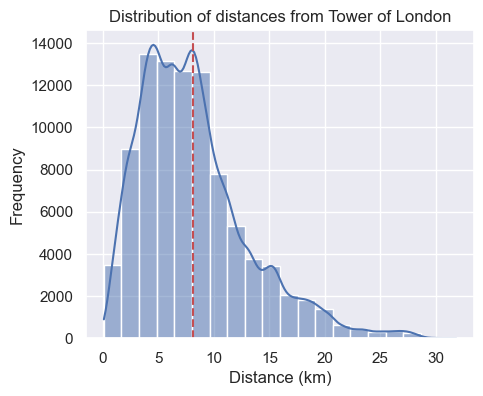

Mean distance to British_Museum is: 7.478 km


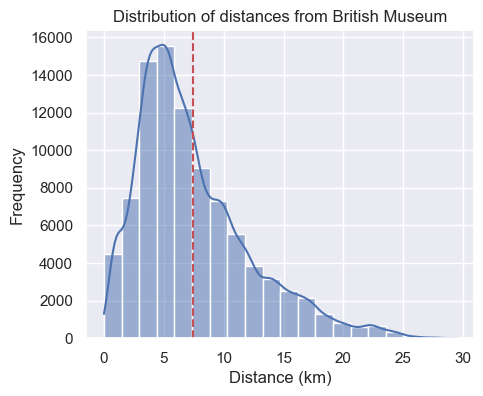

Mean distance to London_Eye is: 7.533 km


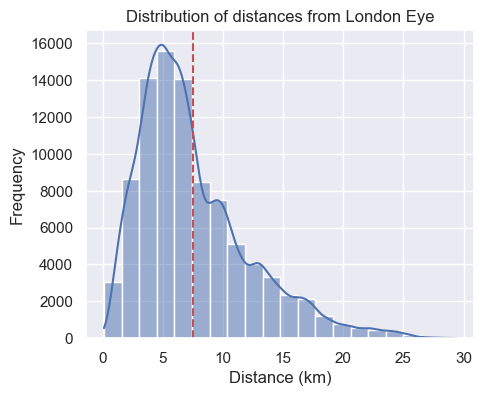

Mean distance to National_Gallery is: 7.453 km


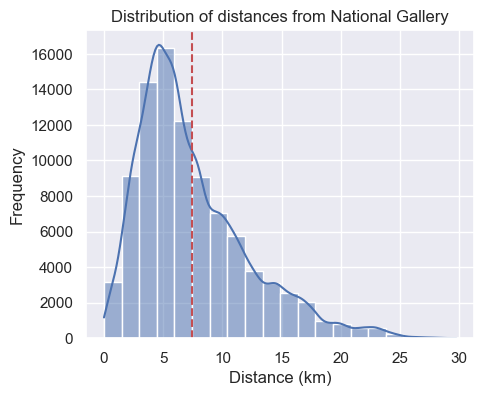

Mean distance to Tower_Bridge is: 8.176 km


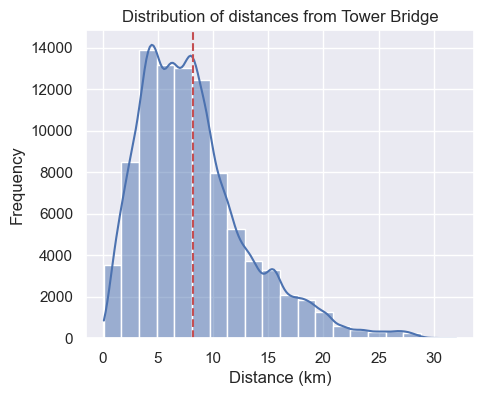

Mean nearest distance to an attraction is: 6.290 km


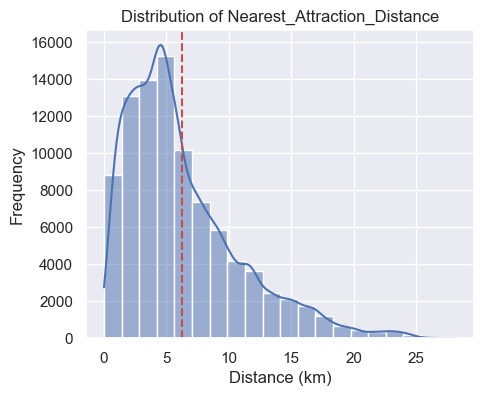

Mean average distance to an attraction is: 7.753 km


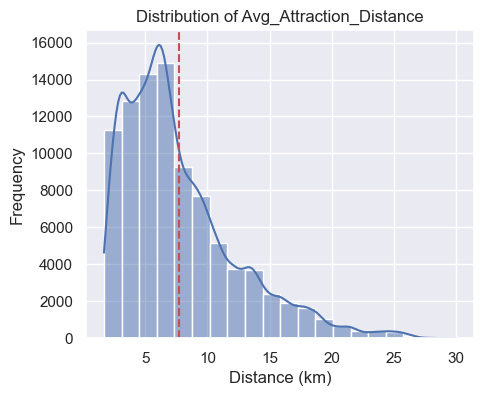

In [7]:
# Look at the distributions of each of the new features

# Distribution of <Attraction_Name>_Distance
for attract_name, _ in attract_coords:
    plt.figure(figsize=(5, 4))
    sns.histplot(listings[attract_name + '_Distance'], bins=20, kde=True)
    # Calculate mean distance
    mean_distance = listings[attract_name + '_Distance'].mean()
    print("Mean distance to {} is: {:.3f} km".format(attract_name, mean_distance))
    # Add mean as vertical line
    plt.axvline(mean_distance, color='r', linestyle='--', label=f'Mean: {mean_distance:.2f} km')
    plt.title(f'Distribution of distances from {attract_name.replace("_", " ")}')
    plt.xlabel('Distance (km)')
    plt.ylabel('Frequency')
    plt.show()

# Distribution of Nearest_Attraction_Distance
plt.figure(figsize=(5, 4))
sns.histplot(listings['Nearest_Attraction_Distance'], bins=20, kde=True)
# Calculate mean distance
mean_distance = listings['Nearest_Attraction_Distance'].mean()
print("Mean nearest distance to an attraction is: {:.3f} km".format(mean_distance))
# Add mean as vertical line
plt.axvline(mean_distance, color='r', linestyle='--', label=f'Mean: {mean_distance:.2f} km')
plt.title(f'Distribution of Nearest_Attraction_Distance')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.show()

# Distribution of Average_Attraction_Distance
plt.figure(figsize=(5, 4))
sns.histplot(listings['Avg_Attraction_Distance'], bins=20, kde=True)
# Calculate mean distance
mean_distance = listings['Avg_Attraction_Distance'].mean()
print("Mean average distance to an attraction is: {:.3f} km".format(mean_distance))
# Add mean as vertical line
plt.axvline(mean_distance, color='r', linestyle='--', label=f'Mean: {mean_distance:.2f} km')
plt.title(f'Distribution of Avg_Attraction_Distance')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.show() 

# Correlation Analysis

In [8]:
# Read in Calendar Dataframe
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_calendar = pd.read_csv(os.path.join(path, "calendar.csv"), low_memory=False)

In [9]:
def get_season(date):
    month = date.month
    if 5 <= month <= 9:
        return 'Tourist'
    else:
        return 'Not Tourist'
    
def is_tourist_season(date):
    return 5 <= date.month <= 9

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91778 entries, 0 to 91777
Data columns (total 83 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            91778 non-null  int64         
 1   listing_url                                   91778 non-null  object        
 2   scrape_id                                     91778 non-null  int64         
 3   last_scraped                                  91778 non-null  datetime64[ns]
 4   source                                        91778 non-null  object        
 5   name                                          91778 non-null  object        
 6   description                                   0 non-null      float64       
 7   neighborhood_overview                         48999 non-null  object        
 8   picture_url                                   91767 non-null  obje

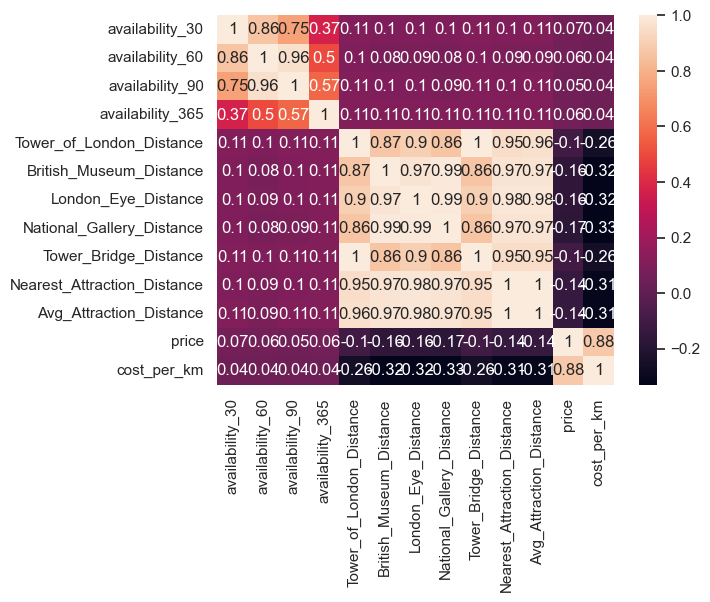

In [51]:
# Find the correlation between the distance to the top 5 attractions and the upcoming availability for a rental property.
# df_superhosts = listings[listings['host_is_superhost'] == 't']
# superhost_listings = df_superhosts['id'].unique().tolist()
# 
# df_calendar['date'] = pd.to_datetime(df_calendar['date'])
# df_calendar['price'] = df_calendar['price'].replace('[$,]', '', regex=True).astype(float)
# df_calendar['adjusted_price'] = df_calendar['adjusted_price'].replace('[$,]', '', regex=True).astype(float)
# print("Calendar Dataframe")
# print(df_calendar.head(50))
# df_calendar.info()
# print("Listings Dataframe")
# print(listings.head(50))
# listings.info()
# 
# filtered_df = df_calendar[df_calendar['listing_id'].isin(superhost_listings)]
# 
# availability_counts = filtered_df.groupby('date')['available'].value_counts().unstack().fillna(0)
# 
# # Calculate the percentage of unavailable properties for each date
# availability_counts['unavailable_percentage'] = (availability_counts['f'] / (availability_counts['t'] + availability_counts['f'])) * 100
# 
# # Plot the percentage of unavailable properties over time
# plt.figure(figsize=(10, 6))
# availability_counts['unavailable_percentage'].plot(kind='line', marker='o', color='r')
# plt.title('Percentage of Unavailable Properties Over Time')
# plt.xlabel('Date')
# plt.ylabel('Percentage of Unavailable Properties')
# plt.grid(True)
# plt.show()

# filtered_df['season'] = filtered_df['date'].apply(get_season)
# avail_plot = px.scatter(filtered_df, x='date', y='available', color='season')
# avail_plot.show()

avail_columns = ['availability_30', 'availability_60', 'availability_90', 'availability_365']
dist_columns = ['Tower_of_London_Distance', 'British_Museum_Distance', 'London_Eye_Distance', 'National_Gallery_Distance', 'Tower_Bridge_Distance']
comb_columns = ['Nearest_Attraction_Distance', 'Avg_Attraction_Distance']

listings.info()
print("Price column:")
print(listings['price'])
temp = listings
temp['last_scraped'] = pd.to_datetime(temp['last_scraped'])
# temp['tourist_days_next_90'] = temp['last_scraped'].apply(lambda x: sum(is_tourist_season(x + pd.DateOffset(days=i)) for i in range(90)))
# print(temp['tourist_days_next_90'].head(20))
# temp['price'] = temp['price'].str.replace('$', '').str.replace(',', '').astype(float)
# temp = temp[(temp['price'] > 100.0) & (temp['price'] < 250.0)]
# temp['host_acceptance_rate'] = temp['host_acceptance_rate'].str.replace('%', '').astype(float)
temp = temp[temp['host_acceptance_rate'] > 0]
temp = temp.dropna(subset=['host_acceptance_rate'])
temp = temp[temp['has_availability'] == 't']
temp = temp[temp['availability_365'] > 0]
temp['cost_per_km'] = temp['price'] / temp['Avg_Attraction_Distance']
df_distances = temp[avail_columns + dist_columns + comb_columns + ['Nearest_Attraction_Name']+['room_type']]

temp_plot = px.scatter(df_distances, x='Avg_Attraction_Distance', y='availability_60', title="Avg_Attraction_Distance Versus Availability in 30 Days", color='room_type')
temp_plot.show()

df_distances = temp[avail_columns + dist_columns + comb_columns + ['price'] + ['cost_per_km']]

corr = df_distances.corr(method='pearson').round(2)
corr_map = sns.heatmap(corr, annot=True)


# Creating a Model

In [44]:
# ----- Perform Correlation Analysis ----- #
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def train_test(model, train, test, x_columns, y_column):
    y_train = train[y_column]    
    y_test = test[y_column]
    x_train = train[x_columns]
    x_test = test[x_columns]

    # Evaluate performance with regular sale price
    model.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    print("RMSE train: {}".format(rmse(y_train, y_pred_train)))
    print("RMSE test: {}".format(rmse(y_test, y_pred_test)))

    return y_pred_train, y_pred_test

def plot_results(df_results, title, y_column):
    x_data = y_column
    y_data = 'pred_' + y_column
    fig_results = px.scatter(df_results, x=x_data, y=y_data, title=title, color='train_or_test')
    fig_results.add_shape(type='line', x0=0, y0=0, x1=df_results[x_data].max(), y1=df_results[x_data].max(),
    line=dict(color='red', dash='dash'), name='y=x')
    return fig_results

# ---- Create Model ----
model_GBR = GradientBoostingRegressor()
model_linear = LinearRegression()
model_ridge = Ridge(alpha=0.5)
model_lasso = Lasso(alpha=0.1)
model_elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)  
model_RF = RandomForestRegressor(n_estimators=66, random_state=42)

# ---- Split into training/testing data ----
train, test = train_test_split(df_distances, test_size=0.2, shuffle=True) # was 'listings'
train = train[comb_columns + avail_columns]
train.loc[:, 'train_or_test'] = 'Train'
test = test[comb_columns + avail_columns]
test.loc[:, 'train_or_test'] = 'Test'

# Create copies of the training and testing data or comparison with Model B
copy_train_B = train.copy()
copy_test_B = test.copy()
copy_train_C = train.copy()
copy_test_C = test.copy()

# # ---- Model A ----
# print("Regression Using Average Attraction Distance and Nearest Attraction Distance")
# for avail_column in avail_columns:
#     print('--- Plot of Comb Columns Versus {} ---'.format(avail_column))
#     y_pred_train, y_pred_test = train_test(model_GBR, train, test, comb_columns, avail_column)
#     train.loc[:, 'pred_' + avail_column] = y_pred_train
#     test.loc[:, 'pred_' + avail_column] = y_pred_test
#     results_A = pd.concat([train, test], ignore_index=True)
#     fig_results_A = plot_results(results_A, "Comb Columns Versus "+avail_column, avail_column)
#     fig_results_A.show()

# # ---- Model B: Only using nearest attraction distance ----
# print("Regression Using Only Nearest Attraction Distance")
# copy_train_B = copy_train_B[['Nearest_Attraction_Distance'] + ['train_or_test'] + avail_columns]
# copy_test_B = copy_test_B[['Nearest_Attraction_Distance'] + ['train_or_test'] + avail_columns]
# for avail_column in avail_columns:
#     print('--- Plot of Nearest_Attraction_Distance Versus {} ---'.format(avail_column))
#     y_pred_train, y_pred_test = train_test(model_GBR, copy_train_B, copy_test_B, ['Nearest_Attraction_Distance'], avail_column)
#     copy_train_B.loc[:, 'pred_' + avail_column] = y_pred_train
#     copy_test_B.loc[:, 'pred_' + avail_column] = y_pred_test
#     results_A = pd.concat([copy_train_B, copy_test_B], ignore_index=True)
#     fig_results_A = plot_results(results_A, "Nearest_Attraction_Distance Versus "+avail_column, avail_column)
#     fig_results_A.show()

# ---- Model C: Only using average attraction distance ----
print("Regression Using Only Average Attraction Distance")
copy_train_C = copy_train_C[['Avg_Attraction_Distance'] + ['train_or_test'] + avail_columns]
copy_test_C = copy_test_C[['Avg_Attraction_Distance'] + ['train_or_test'] + avail_columns]
for avail_column in avail_columns:
    print('--- Plot of Avg_Attraction_Distance Versus {} ---'.format(avail_column))
    y_pred_train, y_pred_test = train_test(model_GBR, copy_train_C, copy_test_C, ['Avg_Attraction_Distance'], avail_column)
    copy_train_C.loc[:, 'pred_' + avail_column] = y_pred_train
    copy_test_C.loc[:, 'pred_' + avail_column] = y_pred_test
    results_A = pd.concat([copy_train_C, copy_test_C], ignore_index=True)
    fig_results_A = plot_results(results_A, "Avg_Attraction_Distance and Availability_30 Versus "+avail_column, avail_column)
    fig_results_A.show()

Regression Using Only Average Attraction Distance
--- Plot of Avg_Attraction_Distance Versus availability_30 ---
RMSE train: 9.238277370602546
RMSE test: 9.268408673066789


--- Plot of Avg_Attraction_Distance Versus availability_60 ---
RMSE train: 18.95545770924646
RMSE test: 19.04352476901775


--- Plot of Avg_Attraction_Distance Versus availability_90 ---
RMSE train: 29.125219019637377
RMSE test: 29.216428974001143


--- Plot of Avg_Attraction_Distance Versus availability_365 ---
RMSE train: 120.88846626854372
RMSE test: 121.9949720913669
